### Original Article: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# LSTM Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

    Forget Gate: conditionally decides what information to throw away from the block.
    Input Gate: conditionally decides which values from the input to update the memory state.
    Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(7)

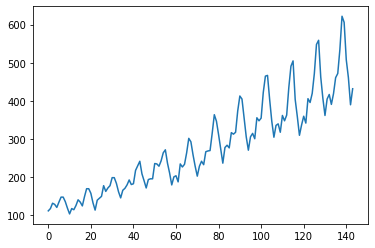

In [9]:
dataframe = pd.read_csv("./data/airline-passengers.csv", usecols=[1], engine='python')
plt.plot(dataframe)
plt.show()

# LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we get started, let’s first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [12]:
# convert values to float
dataset = dataframe.values.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [16]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [18]:
# split test and train data
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [19]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [21]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

2021-07-10 16:16:08.818990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-10 16:16:08.819044: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-10 16:16:08.819089: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ryan-Precision-5520): /proc/driver/nvidia/version does not exist
2021-07-10 16:16:08.819469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-10 16:16:09.275180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the

Epoch 1/100
94/94 - 15s - loss: 0.0441
Epoch 2/100
94/94 - 0s - loss: 0.0212
Epoch 3/100
94/94 - 0s - loss: 0.0165
Epoch 4/100
94/94 - 0s - loss: 0.0152
Epoch 5/100
94/94 - 0s - loss: 0.0141
Epoch 6/100
94/94 - 0s - loss: 0.0131
Epoch 7/100
94/94 - 0s - loss: 0.0120
Epoch 8/100
94/94 - 0s - loss: 0.0111
Epoch 9/100
94/94 - 0s - loss: 0.0100
Epoch 10/100
94/94 - 0s - loss: 0.0091
Epoch 11/100
94/94 - 0s - loss: 0.0082
Epoch 12/100
94/94 - 0s - loss: 0.0073
Epoch 13/100
94/94 - 0s - loss: 0.0065
Epoch 14/100
94/94 - 0s - loss: 0.0056
Epoch 15/100
94/94 - 0s - loss: 0.0050
Epoch 16/100
94/94 - 0s - loss: 0.0044
Epoch 17/100
94/94 - 0s - loss: 0.0037
Epoch 18/100
94/94 - 0s - loss: 0.0034
Epoch 19/100
94/94 - 0s - loss: 0.0030
Epoch 20/100
94/94 - 0s - loss: 0.0027
Epoch 21/100
94/94 - 0s - loss: 0.0025
Epoch 22/100
94/94 - 0s - loss: 0.0023
Epoch 23/100
94/94 - 0s - loss: 0.0022
Epoch 24/100
94/94 - 0s - loss: 0.0022
Epoch 25/100
94/94 - 0s - loss: 0.0021
Epoch 26/100
94/94 - 0s - loss: 0

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [24]:
# make prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train score: %.2f RMSE' %(trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test score: %.2f RMSE' %(trainScore))


Train score: 22.65 RMSE
Test score: 22.65 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

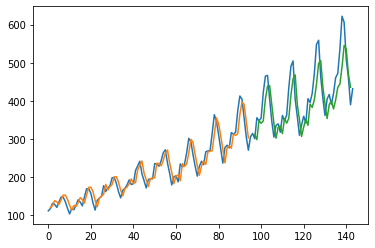

In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM for Regression Using the Window Method

We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

A sample of the dataset with this formulation looks as follows: